# IgBLAST

Given the following FASTQ file:
- Convert to FASTA
- Use IgBLAST to assign germline V, D, and J segments
- Post-process using Change-O.

##  Convert FASTQ to FASTA

In [8]:
from Bio import SeqIO
SeqIO.convert('SRR765688.fastq','fastq','SRR765688.fasta','fasta') 

100

## Set up IgBLAST

In [1]:
%%bash
wget -r -nH --cut-dirs=4 --no-parent ftp://ftp.ncbi.nih.gov/blast/executables/igblast/release/internal_data
wget -r -nH --cut-dirs=4 --no-parent ftp://ftp.ncbi.nih.gov/blast/executables/igblast/release/optional_file

--2016-10-22 06:58:05--  ftp://ftp.ncbi.nih.gov/blast/executables/igblast/release/internal_data
           => ‘.listing’
Resolving ftp.ncbi.nih.gov (ftp.ncbi.nih.gov)... 130.14.250.11, 2607:f220:41e:250::13
Connecting to ftp.ncbi.nih.gov (ftp.ncbi.nih.gov)|130.14.250.11|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /blast/executables/igblast/release ... done.
==> PASV ... done.    ==> LIST ... done.

     0K                                                        15.6K=0.04s

2016-10-22 06:58:07 (15.6 KB/s) - ‘.listing’ saved [599]

Removed ‘.listing’.
--2016-10-22 06:58:07--  ftp://ftp.ncbi.nih.gov/blast/executables/igblast/release/internal_data/internal_data
           => ‘internal_data/.listing’
==> CWD (1) /blast/executables/igblast/release/internal_data ... done.
==> PASV ... done.    ==> LIST ... done.

     0K                                                         227K=0.001s

2016-10-22 06:58:0

In [4]:
%%bash
mkdir database
# V-segment database
perl ./edit_imgt_file.pl IMGT_Human_IGHV.fasta > database/human_igh_v
makeblastdb -parse_seqids -dbtype nucl -in database/human_igh_v
# D-segment database
perl ./edit_imgt_file.pl IMGT_Human_IGHD.fasta > database/human_igh_d
makeblastdb -parse_seqids -dbtype nucl -in database/human_igh_d
# J-segment database
perl ./edit_imgt_file.pl IMGT_Human_IGHJ.fasta > database/human_igh_j
makeblastdb -parse_seqids -dbtype nucl -in database/human_igh_j



Building a new DB, current time: 10/22/2016 07:01:03
New DB name:   /home/simon/Projects/aairr16/solutions/database/human_igh_v
New DB title:  database/human_igh_v
Sequence type: Nucleotide
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 350 sequences in 0.00901294 seconds.


Building a new DB, current time: 10/22/2016 07:01:03
New DB name:   /home/simon/Projects/aairr16/solutions/database/human_igh_d
New DB title:  database/human_igh_d
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /home/simon/Projects/aairr16/solutions/database/human_igh_d
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 44 sequences in 0.00116992 seconds.


Building a new DB, current time: 10/22/2016 07:01:03
New DB name:   /home/simon/Projects/aairr16/solutions/database/human_igh_j
New DB title:  database/human_igh_j
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named

## Obtain reference sequences

Go to [http://www.imgt.org/vquest/refseqh.html](http://www.imgt.org/vquest/refseqh.html) and download IGHV, IGHD, and IGHJ sequences for humans in FASTA format. Save them as `IMGT_Human_IGHV.fasta` etc..

(For advanced users, one could download the whole database from [here](http://www.imgt.org/download/GENE-DB/) and postprocess.)

## Use IgBLAST

IgBLAST has many options (see below) but the most important ones are as follows:

- germline_db_V: the V gene database
- germline_db_D: the D gene database
- germline_db_J: the J gene database
- auxiliary_data: contains annotations for the sequences
- domain_system: the system used (e.g. imgt) for defining the domains
- ig_seqtype: Ig or TCR
- organism: e.g. human, mouse
- outfmt: the output format; for postprocessing with ChangeO, has to be '7 std qseq sseq btop'
- query: the input data in FASTA format
- out: the output filename
- num_threads: the number of threads to use

In [1]:
!igblastn -help

USAGE
  igblastn [-h] [-help] [-import_search_strategy filename]
    [-export_search_strategy filename] [-germline_db_V germline_database_name]
    [-num_alignments_V int_value] [-germline_db_V_seqidlist filename]
    [-germline_db_D germline_database_name] [-num_alignments_D int_value]
    [-germline_db_D_seqidlist filename]
    [-germline_db_J germline_database_name] [-num_alignments_J int_value]
    [-germline_db_J_seqidlist filename] [-auxiliary_data filename]
    [-min_D_match min_D_match] [-D_penalty D_penalty]
    [-organism germline_origin] [-domain_system domain_system]
    [-ig_seqtype sequence_type] [-focus_on_V_segment] [-show_translation]
    [-db database_name] [-dbsize num_letters] [-gilist filename]
    [-seqidlist filename] [-negative_gilist filename]
    [-entrez_query entrez_query] [-db_soft_mask filtering_algorithm]
    [-db_hard_mask filtering_algorithm] [-subject subject_input_file]
    [-subject_loc range] [-query input_file] [-out output_file]
    [-evalue evalu

Complete the following cell to run `SRR765688,fasta` against the IGH databases generated previously. Ensure that the outfmt term is '7 std qseq sseq btop', and save the output as `SRR765688.fmt7`.

In [12]:
%%bash
igblastn \
    -germline_db_V database/human_igh_v \
    -germline_db_D database/human_igh_d \
    -germline_db_J database/human_igh_j \
    -auxiliary_data optional_file/human_gl.aux \
    -domain_system imgt -ig_seqtype Ig -organism human \
    -outfmt '7 std qseq sseq btop' \
    -query SRR765688.fasta \
    -out SRR765688.fmt7

## Postprocess IgBLAST

In [14]:
%%bash
MakeDb.py igblast -i SRR765688.fmt7 -s SRR765688.fasta -r IMGT_Human_IGH[VDJ].fasta \
    --regions --scores

        START> MakeDB
      ALIGNER> IgBlast
ALIGN_RESULTS> SRR765688.fmt7
     SEQ_FILE> SRR765688.fasta
     NO_PARSE> False
 SCORE_FIELDS> True
REGION_FIELDS> True

PROGRESS> 07:54:56 [####################] 100% (2,561) 0.2 min

OUTPUT> SRR765688_db-pass.tab
  PASS> 2553
  FAIL> 8
   END> MakeDb



In [15]:
%%bash
ParseDb.py split -d SRR765688_db-pass.tab -f FUNCTIONAL

    START> ParseDb
  COMMAND> split
     FILE> SRR765688_db-pass.tab
    FIELD> FUNCTIONAL
NUM_SPLIT> None

PROGRESS> 07:55:05 [####################] 100% (2,553) 0.0 min

OUTPUT1> SRR765688_db-pass_FUNCTIONAL-F.tab
OUTPUT2> SRR765688_db-pass_FUNCTIONAL-T.tab
RECORDS> 2553
  PARTS> 2
    END> ParseDb



In [2]:
%load_ext rpy2.ipython

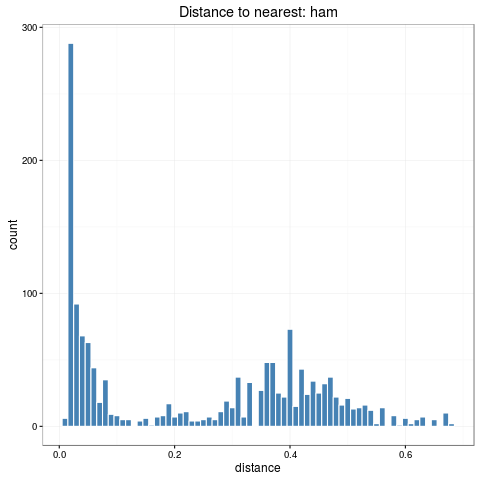

In [4]:
%%R
library(ggplot2)
library(alakazam)
library(shazam)
db <- readChangeoDb("SRR765688_db-pass_FUNCTIONAL-T.tab")
db <- distToNearest(db, model="ham", symmetry="min")
p1 <- ggplot() + theme_bw() + 
    ggtitle("Distance to nearest: ham") + xlab("distance") +
    geom_histogram(data=db, aes(x=DIST_NEAREST), binwidth=0.01, 
                   fill="steelblue", color="white")
plot(p1)

**Look at the above histogram, and decide what a good cutoff is for defining a clone, then add this to the end of the following command.**

In [5]:
%%bash
DefineClones.py bygroup -d SRR765688_db-pass_FUNCTIONAL-T.tab --act set --model ham \
--sym min --norm len --dist 0.13

     START> DefineClones
   DB_FILE> SRR765688_db-pass_FUNCTIONAL-T.tab
GROUP_FUNC> indexJunctions
GROUP_ARGS> {'mode': 'gene', 'action': 'set', 'fields': None}
CLONE_FUNC> distanceClones
CLONE_ARGS> {'model': 'ham', 'norm': 'len', 'distance': 0.13, 'seq_field': 'JUNCTION', 'sym': 'min', 'linkage': 'single'}
     NPROC> 4

PROGRESS> Grouping sequences
PROGRESS> 11:49:13 (1972) 0.0 min

PROGRESS> Assigning clones
PROGRESS> 11:49:16 [####################] 100% (1,972) 0.0 min

 OUTPUT> SRR765688_db-pass_FUNCTIONAL-T_clone-pass.tab
 CLONES> 1133
RECORDS> 1972
   PASS> 1972
   FAIL> 0
    END> DefineClones



In [6]:
%%bash
CreateGermlines.py -d SRR765688_db-pass_FUNCTIONAL-T_clone-pass.tab -r IMGT_Human_IGH[VDJ].fasta \
    -g dmask --cloned

     START> CreateGermlines
   DB_FILE> SRR765688_db-pass_FUNCTIONAL-T_clone-pass.tab
GERM_TYPES> dmask
    CLONED> True
   V_FIELD> V_CALL
 SEQ_FIELD> SEQUENCE_IMGT

PROGRESS> 11:49:50 [####################] 100% (1,972) 0.0 min

 OUTPUT> SRR765688_db-pass_FUNCTIONAL-T_clone-pass_germ-pass.tab
 CLONES> 1133
RECORDS> 1972
   PASS> 1971
   FAIL> 1
    END> CreateGermlines



In [8]:
import pandas as pd
db=pd.read_csv("SRR765688_db-pass_FUNCTIONAL-T_clone-pass_germ-pass.tab",sep="\t")
db

,SEQUENCE_ID,SEQUENCE_INPUT,FUNCTIONAL,IN_FRAME,STOP,MUTATED_INVARIANT,INDELS,V_CALL,D_CALL,J_CALL,...,CDR1_IMGT,CDR2_IMGT,CDR3_IMGT,SEQORIENT,MID,CPRIMER,VPRIMER,DUPCOUNT,CLONE,GERMLINE_IMGT_D_MASK
0,SRR765688.113627 HQP9GKT01BSFQV length=358,NNNNNNNNNNNNNNNNNNNNGCTGACCTGCACCTTCTCTGGGTTCT...,T,T,F,NaN,F,IGHV2-5*02,"IGHD2-2*01,IGHD2-2*03,IGHD2-8*01",IGHJ2*01,...,GGGTTCTCACTCAGC......ACTAGTGGAGTGGGT,ATTTATTGGGAT.........GATGATAAG,GCACGCGTGTACGGCCAGGCCAATGCCGATCTC,"F,F,F",MID53,IgG-PCR,LR8,3,1,CAGATCACCTTGAAGGAGTCTGGTCCT...ACGCTGGTGAAACCCA...
1,SRR765688.234313 HQP9GKT02FUORE length=370,NNNNNNNNNNNNNNNNNACCTTCAGTAGCTATAGCATGAACTGGGT...,T,T,F,NaN,F,"IGHV3-21*01,IGHV3-21*02","IGHD2-2*01,IGHD2-2*02,IGHD2-2*03",IGHJ6*02,...,......ACCTTC............AGTAGCTATAGC,ATTAGTAGTAGT......AGTAGTTACATA,GCGAGATGCCCAGTACTACCAGCTGCTAGTACTTACTACTACTACT...,"F,RC,F",MID53,IgA-PCR,LR11,2,2,GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCCTGGTCAAGCCTG...
2,SRR765688.276694 HQP9GKT02H22MA length=407,NNNNNNNNNNNNNNNNNNNNAAGCCTGGGTCCTCGGTGAAGGTCTC...,T,T,F,NaN,F,"IGHV1-69*01,IGHV1-69*12,IGHV1-69D*01","IGHD4-11*01,IGHD4-4*01",IGHJ6*02,...,GGAGGCAGCTTC............AACCAGTTTGCC,ATCATCCCTAAG......TTTGGGATAAGA,ACGAGTTTATACGGTTCGGGCACTTATTTTTCCAAAAATGACTACA...,"F,RC,F",MID54,IgG-PCR,LR9,2,3,CAGGTGCAGCTGGTGCAGTCTGGGGCT...GAGGTGAAGAAGCCTG...
3,SRR765688.63746 HQP9GKT01AQKUQ length=404,NNNNNNNNNNNNNNNNNNNCTGGGGTCCTCGGTGAAGGTCTCCTGC...,T,T,F,NaN,F,"IGHV1-69*01,IGHV1-69*12,IGHV1-69D*01",IGHD2-15*01,IGHJ6*02,...,GGAGGCACTTTC............AGCAGTTATGCT,ATCATCCCTATG......TCTGATACAGTA,GCGAGAAATCCTACTGTAGTGGTGCCTACTCCTGAGAAGGAGGTCT...,"F,RC,F",MID54,IgA-PCR,LR2,2,4,CAGGTGCAGCTGGTGCAGTCTGGGGCT...GAGGTGAAGAAGCCTG...
4,SRR765688.140353 HQP9GKT01DKFUY length=381,NNNNNNNNNNNNNNNNNNNNACTGACCTGCACCTTCTCTGGATTCT...,T,T,F,NaN,F,IGHV2-70D*04,"IGHD3-10*01,IGHD3-10*02,IGHD3-22*01",IGHJ4*02,...,GGATTCTCACTCAAC......ACGAATGCAATGCGT,ATTGAATGGGAT.........AATTCTAAA,GCTCGGGCTCTCGGAAGTGGAGATGGTCAATATTACTTCGACGAC,"F,F,F",MID53,IgG-PCR,LR8,2,5,CAGGTCACCTTGAAGGAGTCTGGTCCT...GCGCTGGTGAAACCCA...
5,SRR765688.70199 HQP9GKT01CA6OC length=403,NNNNNNNNNNNNNNNNNNNCTTCACAGACCCTGTCCCTCACCTGCA...,T,T,F,NaN,F,IGHV4-31*03,IGHD3-10*01,IGHJ3*02,...,GGTGGCTCCATCAGC......AGTGGTGGTTACTAC,ATCTATTACAGT.........GGGAGCACC,GCGAGAGAGGCATCCTACTACTCTGGTTCGGGGAGTTATTATGAGG...,"F,F,F",MID54,IgG-PCR,LR4,2,6,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGAAGCCTT...
6,SRR765688.130608 HQP9GKT01AOR0A length=371,NNNNNNNNNNNNNNNNNNNNCTGGGGCCTCAGTGAAGGTCTCCTGC...,T,T,F,NaN,F,IGHV1-2*04,IGHD6-13*01,"IGHJ6*02,IGHJ6*04",...,GGATACACCTTC............ATCGGCTACTAT,ATCAATCCTAAC......GATGGTGGCACA,GCGAGAGATGCTCATGGGCCGCAGCTGGGCGGTATGGACGTCTGG,"F,F,F",MID54,IgG-PCR,LR2,3,7,CAGGTGCAGCTGGTGCAGTCTGGGGCT...GAGGTGAAGAAGCCTG...
7,SRR765688.120488 HQP9GKT01B3KGQ length=379,NNNNNNNNNNNNNNNNNNNCTGGGTCCTCGGTGAAGGTCTCCTGCA...,T,T,F,NaN,F,"IGHV1-69*04,IGHV1-69*09","IGHD1-26*01,IGHD4-17*01,IGHD4-23*01",IGHJ3*02,...,GGAGTCACCTTC............AACAATTATGGT,ATCATCTCCCTC......TCTGGTGTAGTG,GCGACAGATGTGGGACCTACGGGGCGGGAGGCTTTTGATATC,"F,RC,F",MID54,IgA-PCR,LR2,2,8,CAGGTCCAGCTGGTGCAGTCTGGGGCT...GAGGTGAAGAAGCCTG...
8,SRR765688.34854 HQP9GKT01AHUAW length=383,NNNNNNNNNNNNNNNNNNNNCTGGGTCCTCGGTGAAGGTCTCCTGC...,T,T,F,NaN,F,"IGHV1-69*01,IGHV1-69*11,IGHV1-69*12","IGHD2/OR15-2a*01,IGHD2/OR15-2b*01",IGHJ3*02,...,GGAGGCTCCTTC............AGTGACTATCCT,CTCATCCCTGTG......CATGAGACTTCA,GCGAGGTCCACTTTCTTTGGAATCCCTGTTTCTTTTGATATC,"F,RC,F",MID54,IgG-PCR,LR2,4,9,CAGGTGCAGCTGGTGCAGTCTGGGGCT...GAGGTGAAGAAGCCTG...
9,SRR765688.126375 HQP9GKT01DMI4V length=368,NNNNNNNNNNNNNNNNNNNNACTGACGTGTTCCTTTTCTGGGTTCT...,T,T,F,NaN,F,IGHV2-5*02,"IGHD1-7*01,IGHD3-16*02",IGHJ5*02,...,GGGTTCTCTCTCACC......ACTACTGGAGTGGCT,ATTTTTTGGGAT.........GATGATAAG,GTACACAGATCCGTTATACTGGGAACTACTCCCTTTGACACC,"F,F,F",MID54,IgG-PCR,LR8,2,10,CAGATCACCTTGAAGGAGTCTGGTCCT...ACGCTGGTGAAACCCA...
